In [2]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import jax
import jax.random as random
from copy import deepcopy
import time


In [3]:
#Some lenstronomy imports
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# # import lens model solver with 4 image positions constrains
# from lenstronomy.LensModel.Solver.solver4point import Solver4Point


In [4]:
# from helens import LensEquationSolver
from herculens.Util import param_util
import functools
import herculens as hcl
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)

In [5]:
key = random.PRNGKey(42)
key

Array([ 0, 42], dtype=uint32)

In [6]:
# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal


# #Helens
# from helens import LensEquationSolver

In [7]:
import dynesty
from dynesty import plotting as dyplot
import corner 
import matplotlib.pyplot as plt

In [8]:
def get_time_delay_distance(z_lens, z_source, cosmo = cosmo):
    ''' Returns the time delay distance in Mpc between a lens at redshift z_lens and a source at redshift z_source '''
    Dds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
    Ds = cosmo.angular_diameter_distance(z_source)
    Dd = cosmo.angular_diameter_distance(z_lens)
    D_dt = (1+z_lens)*Ds*Dd/Dds
    return D_dt # In units of Mpc

arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 

In [9]:
# Define the pixel grid
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (Array(-3.16, dtype=float64), Array(3.16, dtype=float64)) arcsec
y range    : (Array(-3.16, dtype=float64), Array(3.16, dtype=float64)) arcsec


In [10]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 1#0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 1.0 # Einstein radius
y0true = 0.8
y1true = 0.00
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIS"])


#SIS for validation and first pass
kwargs_lens_true_sis = [
    {'theta_E': theta_E_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIS
]
kwargs_lens_true_sie = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

0.0 0.0


In [11]:
# Define classes for lenstronomy
lensModel = LensModel(lens_model_list=['SIS'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# compute image position of full model (with numerical options attached)
x_image_true, y_image_true = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_true_sis,sourcePos_x=y0true, sourcePos_y=y1true,min_distance=0.001, search_window=5, precision_limit=10**(-10), num_iter_max=1200,solver='lenstronomy')
print('image positions (x coordinates): ', x_image_true)
print('image positions (y coordinates): ', y_image_true)

# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image_true, y_image_true, kwargs_lens_true_sis)
print("the relative precision of the image positions are: ", x_source_new - y0true)



image positions (x coordinates):  [ 1.8 -0.2]
image positions (y coordinates):  [4.66304001e-15 5.70197568e-21]
the relative precision of the image positions are:  [4.5519144e-15 0.0000000e+00]


In [12]:
#Define ray shooting function
def ray_shooting_func(theta_x, theta_y, kwargs_lens):
    """Function that computes evaluates the lens equation to return beta = theta - alpha(theta)"""
    beta_x, beta_y = lens_mass_model.ray_shooting(theta_x, theta_y, kwargs_lens)
    return beta_x, beta_y

print("Testing ray shooting function:")
print(ray_shooting_func(x_image_true, y_image_true, kwargs_lens_true_sis))

Testing ray shooting function:
(Array([0.80003334, 0.79996666], dtype=float64), Array([ 6.66706667e-05, -6.66706667e-05], dtype=float64))


In [13]:
# # #Helens
# from helens import LensEquationSolver

# # Set up the Helens solver

# #This line creates a pixel grid for the solver with half the original pixel scale (higher resolution)
# solver_pixel_grid = pixel_grid.create_model_grid(pixel_scale_factor=0.1)

# # Retrieve the pixel coordinates as 2D arrays
# solver_grid_x, solver_grid_y = solver_pixel_grid.pixel_coordinates
# print(solver_grid_x.shape)

# #Set the solver function
# solver = LensEquationSolver(solver_grid_x, solver_grid_y, ray_shooting_func)

# # Hyperparameters of the solver
# solver_params = {
#     # You have to specify the number of predicted images in advance
#     'nsolutions': 3,

#     # Hyperparameters (see docstring above)
#     'niter': 4, 
#     'scale_factor': 1.5, 
#     'nsubdivisions': 6,
# }

# # T0 KNOW MORE ABOUT THESE PARAMS USE THIS
# #?LensEquationSolver.solve

# #Based on your the grid resolution, 
# #you can obtain a rough estimate of the solver accuracy of the predicted positions in image plane.

# estim_acc = solver.estimate_accuracy(
#     solver_params['niter'], 
#     solver_params['scale_factor'], 
#     solver_params['nsubdivisions']
# )
# print(f"Estimated accuracy in image plane (arcsec): {estim_acc:.2e}")

# # Set the source position
# some_beta_x, some_beta_y = y0true, y1true
# some_beta = jnp.array([some_beta_x, some_beta_y])  

# # Start timing
# start_time = time.time()

# _ = solver.solve(
#     some_beta, kwargs_lens_true_sis, 
#     **solver_params
# )  # takes some time to JIT-compile

# # End timing
# end_time = time.time()
# print(f"Execution time: {end_time - start_time:.2f} seconds")


In [14]:
# some_beta_x_, some_beta_y_ = 0.18, 0.0
# some_beta_ = jnp.array([some_beta_x_, some_beta_y_])

# start_time = time.time()

# result_thetas, result_betas = solver.solve(
#     some_beta_, kwargs_lens_true_sis,
#     **solver_params
# )  # this is now very fast and differentiable!

# # End timing
# end_time = time.time()
# print(f"Execution time: {end_time - start_time:.2f} seconds")

# print(result_betas)
# print(result_thetas)

In [15]:
# Get the true GW observables
#So to get dimensionless potential divide by einstein_rad^2
fermat_potential_true = lens_mass_model.fermat_potential(x_image_true,y_image_true,kwargs_lens_true_sis)/theta_E_true**2
print('Fermat Potential (Herculens):', fermat_potential_true)
print('Fermat Potential Difference:', jnp.diff(fermat_potential_true))
print('_'*50)

time_delay_distance_true = get_time_delay_distance(zl_true, zs_true,cosmo=cosmo) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)
Tstar_true = (time_delay_distance_true.to(u.m)/const.c)  * (theta_E_true * arcsecond_to_radians)**2
print('Tstar_true (D_dt*theta_E^2/c):', Tstar_true)

arrival_times_true = Tstar_true*fermat_potential_true
print('Arrival times:', arrival_times_true)
print('_'*80)

magnifications_true = lens_mass_model.magnification(x_image_true,y_image_true,kwargs_lens_true_sis)
print('Magnification (Herculens)', magnifications_true)

print('_'*80)

print('Sorting images according to their arrival times')
idx_sort = jnp.argsort(arrival_times_true)
x_image_true = x_image_true[idx_sort]; 
y_image_true = y_image_true[idx_sort]; 
fermat_potential_true = fermat_potential_true[idx_sort]; 
magnifications_true = magnifications_true[idx_sort]; 
arrival_times_true = arrival_times_true[idx_sort]; 
print('Sorted Arrival Times:', arrival_times_true)
time_delays_true = jnp.diff(arrival_times_true)*u.s # Set time delays
print('Time delay (difference bet arrival time in order):', time_delays_true)
print('_'*50)

# Get the effective luminosity distances
dL_true = cosmo.luminosity_distance(zs_true)
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
print('True luminosity distance (in Mpc):', dL_true)

print('\n' + '*'*40 + ' GW Observables ' + '*'*40)
print('Time delays (in days):', time_delays_true.to(u.day))
print('Effective dL:', dL_effectives_true)
print('\n' + '*'*40 + ' GW Observables ' + '*'*40)


Fermat Potential (Herculens): [-1.29997333  0.29997333]
Fermat Potential Difference: [1.59994666]
__________________________________________________
Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3073.3632080390958 Mpc
Tstar_true (D_dt*theta_E^2/c): 7435213.8456442775 s
Arrival times: [-9665579.67580413  2230365.8680699 ] s
________________________________________________________________________________
Magnification (Herculens) [ 2.25027225 -0.24996881]
________________________________________________________________________________
Sorting images according to their arrival times
Sorted Arrival Times: [-9665579.67580413  2230365.8680699 ] s
Time delay (difference bet arrival time in order): [11895945.54387403] s
__________________________________________________
True luminosity distance (in Mpc): 15924.566651659155 Mpc

**************************************** GW Observables ****************************************
Time delays (in days): [137.68455491] d
Effective dL: [10615.7

In [16]:
# class ProbModel(hcl.NumpyroModel):
    
#     def model(self):
#         # Parameters of the source
#         prior_source = [
#           {
#               'amp': numpyro.sample('source_amp', dist.LogNormal(1.0, 0.1)),
#          'R_sersic': numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.2, 0.1, low=0.05)), 
#          'n_sersic': numpyro.sample('source_n', dist.Uniform(1., 3.)), 
#          'e1': numpyro.sample('source_e1', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
#          'e2': numpyro.sample('source_e2', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
#          'center_x': numpyro.sample('source_center_x', dist.Normal(0.05, 0.02)), 
#         'center_y': numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))}
#         ]

#         # Parameters of the lens light that are used for the lens mass
#         cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
#         cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))
#         e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
#         e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))

#         # Parameters of the lens light, with center relative the lens mass
#         prior_lens_light = [
#         {'amp': numpyro.sample('light_amp', dist.LogNormal(2., 0.1)), 
#          'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.1)), 
#          'n_sersic': numpyro.sample('light_n', dist.Uniform(2., 5.)), 
#          'e1': e1,
#          'e2': e2,
#          'center_x': cx, 
#          'center_y': cy}
#         ]

#         prior_lens = [
#         # power-law
#         {
#             'theta_E': numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1)),
#          'e1': numpyro.sample('lens_e1', dist.Normal(e1, 0.005)),
#          'e2': numpyro.sample('lens_e2', dist.Normal(e2, 0.005)),
#          'center_x': numpyro.sample('lens_center_x', dist.Normal(cx, 0.005)), 
#          'center_y': numpyro.sample('lens_center_y', dist.Normal(cy, 0.005))},
#         # # external shear, with fixed origin
#         # {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
#         #  'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
#         #  'ra_0': 0.0, 'dec_0': 0.0}
#         ]
#         print(prior_lens)
        
#         # wrap up all parameters for the lens_image.model() method
#         model_params = dict(kwargs_lens=prior_lens, 
#                             kwargs_lens_light=prior_lens_light,
#                             kwargs_source=prior_source)
        
#         # generates the model image
#         model_image = lens_image.model(**model_params)
        
#         # estimate the error per pixel
#         sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
#         model_var = noise.C_D_model(model_image, background_rms=sigma_bkg)
#         model_std = jnp.sqrt(model_var)
        
#         # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
#         numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
#     def params2kwargs(self, params):
#         # functions that takes the flatten dictionary of numpyro parameters
#         # and reshape it back to the argument of lens_image.model()
#         kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
#         'e1': params['lens_e1'],
#         'e2': params['lens_e2'],
#         'center_x': params['lens_center_x'],
#         'center_y': params['lens_center_y']},
#         # {'gamma1': params['lens_gamma1'],
#         # 'gamma2': params['lens_gamma2'],
#         # 'ra_0': 0.0,
#         # 'dec_0': 0.0}
#         ],
#         'kwargs_source': [{'amp': params['source_amp'],
#         'R_sersic': params['source_R_sersic'],
#         'n_sersic': params['source_n'],
#         'e1': params['source_e1'],
#         'e2': params['source_e2'],
#         'center_x': params['source_center_x'],
#         'center_y': params['source_center_y']}],
#         'kwargs_lens_light': [{'amp': params['light_amp'],
#         'R_sersic': params['light_R_sersic'],
#         'n_sersic': params['light_n'],
#         'e1': params['light_e1'],
#         'e2': params['light_e2'],
#         'center_x': params['light_center_x'],
#         'center_y': params['light_center_y']}]}
#         return kw

# prob_model = ProbModel()
# n_param = prob_model.num_parameters
# print("Number of parameters:", n_param)


# # visualize initial guess
# key, key_init = jax.random.split(key)
# init_params = prob_model.get_sample(key_init)  # constrained space
# print(init_params)
# init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
# print(init_params_unconst)
# kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
# initial_model = lens_image.model(**kwargs_init)

# fig, axes = plt.subplots(1, 3, figsize=(14, 4))
# ax = axes[0]
# ax.set_title("Initial guess model")
# im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
# plot_util.nice_colorbar(im)
# ax = axes[1]
# ax.set_title("Simulated data")
# im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
# plot_util.nice_colorbar(im)
# ax = axes[2]
# ax.set_title("Difference")
# im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
# plot_util.nice_colorbar(im)
# fig.tight_layout()
# plt.show()



# loss = hcl.Loss(prob_model)
# print("Initial loss =", loss(init_params_unconst))
# #print("Initial gradient =", loss.gradient(init_params_unconst))

# optimizer = hcl.JaxoptOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude
# best_fit, logL_best_fit, extra_fields, runtime \
#     = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
# print("Runtime:", runtime)

# print("Final loss =", loss(best_fit))

# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
# ax.set_ylabel("Loss", fontsize=14)
# ax.set_xlabel("Iteration", fontsize=14)
# plt.show()

# # the best-fit values are in unconstrained space so we transform them here
# best_fit_constrained = prob_model.constrain(best_fit)
# kwargs_best_fit = prob_model.params2kwargs(best_fit_constrained)

# fig = plotter.model_summary(lens_image, 
#                             kwargs_best_fit, 
#                             kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
#                             show_source=True)
# plt.show()

# # print resulting parameters
# print("BEST-FIT VALUES:")
# pprint(kwargs_best_fit)

# print("="*80)

# # compare to input values
# print("INPUT VALUES:")
# pprint(kwargs_all_input)


# #FIM computation
# @jax.jit
# def loss_constrained(params_const):
#     params_unconst = prob_model.unconstrain(params_const)
#     return loss(params_unconst)

# @jax.jit
# def hessian_constrained(params_const):
#     return jax.jacfwd(jax.jacrev(loss_constrained))(params_const)

# fisher_matrix = hessian_constrained(prob_model.constrain(best_fit))  # pytree
# fisher_matrix, _ = jax.flatten_util.ravel_pytree(fisher_matrix)  # get the array
# fisher_matrix = fisher_matrix.reshape((22, 22))  # reshape as a matrix
# cov_matrix = jnp.linalg.inv(fisher_matrix) # invert to get covariance matrix

# mean, unravel_fn = jax.flatten_util.ravel_pytree(prob_model.constrain(best_fit))
# cov = cov_matrix
# fim_samples = jax.vmap(unravel_fn)(np.random.multivariate_normal(mean, cov, size=3000))
# #print(fim_samples)


Tstar_low = 0.5*deepcopy(Tstar_true)
Tstar_high = 2*deepcopy(Tstar_true)

dL_low = 0.5*deepcopy(dL_true)
dL_high = 1.5*deepcopy(dL_true)

Tstar_low, Tstar_high = deepcopy(Tstar_low.value), deepcopy(Tstar_high.value)
dL_low, dL_high = deepcopy(dL_low.value), deepcopy(dL_high.value)
print(Tstar_low, Tstar_high, dL_low, dL_high)


3717606.9228221388 14870427.691288555 7962.283325829578 23886.84997748873


In [18]:
dL_true*0.05

<Quantity 796.22833258 Mpc>

In [20]:
time_delays_true 

<Quantity [11895945.54387403] s>

In [18]:
Tstar_low = 3717606.9228221388
Tstar_high = 14870427.691288555

dL_low = 7962.283325829578
dL_high = 23886.84997748873

In [101]:
class GWProbModel(hcl.NumpyroModel):
    
    def __init__(self, n_images=2, gw_observations=None):
        """
        GW Probabilistic Model for gravitational wave lensing
        
        Parameters:
        -----------
        n_images : int
            Number of lensed images (default: 2)
        gw_observations : dict
            Dictionary containing observed GW data:
            - 'arrival_times': observed arrival times [seconds]
            - 'magnifications': observed magnifications
            - 'dL_eff': observed effective luminosity distances [Mpc]
        """
        self.n_images = n_images
        self.gw_observations = gw_observations or {}
        super().__init__()
    
    def model(self):
        # GW-specific parameters
        # Tstar: time scale parameter (must be positive)
        Tstar = numpyro.sample('Tstar', dist.Uniform(3717606.9228221388, 14870427.691288555))
        
        # dL: original luminosity distance (must be positive)
        dL = numpyro.sample('dL', dist.Uniform(7962.283325829578, 23886.84997748873))
                
        # Image positions (can be negative, so no transformation needed)
        image_positions = []
        for i in range(self.n_images):
            x_pos = numpyro.sample(f'image_x{i+1}', dist.Uniform(-2, 2))
            y_pos = numpyro.sample(f'image_y{i+1}', dist.Uniform(-0.00005, 0.000005))
            image_positions.append((x_pos, y_pos))
        
        # Lens parameters (same as EM model)
        cx = numpyro.sample('lens_center_x', dist.Uniform(-0.00005, 0.00005))
        cy = numpyro.sample('lens_center_y', dist.Uniform(-0.00005, 0.00005))
        #For SIS e1 and e2 are 0
        #e1 = numpyro.sample('lens_e1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        #e2 = numpyro.sample('lens_e2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        theta_E = numpyro.sample('lens_theta_E', dist.Uniform(0.9999, 1.0002))
        
        # Lens mass model
        prior_lens = [{
            'theta_E': theta_E,
            #'e1': e1,
            #'e2': e2,
            'center_x': cx,
            'center_y': cy
        }]
        
        # GW likelihood calculation
        if self.gw_observations:
            gw_loglike = self._compute_gw_likelihood(
                Tstar, dL, image_positions, prior_lens
            )
            numpyro.factor('gw_likelihood', gw_loglike)
    
    def _compute_gw_likelihood(self, Tstar, dL, image_positions, lens_params):
        """
        Compute GW likelihood for lensed gravitational waves
        
        Parameters:
        -----------
        Tstar : float
            Time scale parameter
        dL : float
            Original luminosity distance
        image_positions : list of tuples
            List of (x, y) image positions
        lens_params : list of dict
            Lens mass model parameters
            
        Returns:
        --------
        float
            Log-likelihood value
        """
        # Convert image positions to arrays
        x_images = jnp.array([pos[0] for pos in image_positions])
        y_images = jnp.array([pos[1] for pos in image_positions])
        
        # Create lens mass model
        lens_mass_model = hcl.MassModel(["SIS"])
        
        # Ray shooting to get source positions
        source_positions = []
        for i in range(self.n_images):
            # Ray shoot from image to source
            beta_x, beta_y = lens_mass_model.ray_shooting(
                x_images[i], y_images[i], lens_params
            )
            source_positions.append((beta_x, beta_y))
        
        # Check consistency: all images should map to same source
        source_x = jnp.array([pos[0] for pos in source_positions])
        source_y = jnp.array([pos[1] for pos in source_positions])
        
        # Mean source position
        mean_source_x = jnp.mean(source_x)
        mean_source_y = jnp.mean(source_y)
        
        # Consistency penalty (sum of squared deviations)
        epsilon = 0.001
        consistency_penalty = -0.5*(jnp.sum(((source_x - mean_source_x)**2)/(epsilon**2) + ((source_y - mean_source_y)**2)/(epsilon**2)))
        
        # Calculate Fermat potential for time delays
        fermat_potentials = []
        for i in range(self.n_images):
            phi = lens_mass_model.fermat_potential(
                x_images[i], y_images[i], lens_params
            )
            fermat_potentials.append(phi)
        
        fermat_potentials = jnp.array(fermat_potentials)
        
        # Calculate magnifications
        magnifications = []
        for i in range(self.n_images):
            mu = lens_mass_model.magnification(
                x_images[i], y_images[i], lens_params
            )
            magnifications.append(mu)
        
        magnifications = jnp.array(magnifications)
        
        # Calculate arrival times (proportional to Fermat potential)
        arrival_times = Tstar * fermat_potentials
        
        # Calculate effective luminosity distances
        dL_eff = dL / jnp.sqrt(jnp.abs(magnifications))
        
        idx = jnp.argsort(arrival_times)
    
        sorted_arrival_times = arrival_times[idx]#jnp.sum(time_weights * arrival_times)
        sorted_magnifications = magnifications[idx]#jnp.sum(mag_weights * magnifications)
        sorted_dL_eff = dL_eff[idx]#jnp.sum(mag_weights * dL_eff)
        
        # Compare with observations
        sigma_td = 594797.28#time_delays_true * 0.05
        sigma_dL_eff = 796.22833 #dL_effectives_true * 0.05
        if 'time_delays' in self.gw_observations:
            computed_delays = jnp.diff(sorted_arrival_times)  # Time delays between images
            obs_delays = jnp.array(self.gw_observations['time_delays'])
            time_likelihood = -0.5 * (jnp.sum((computed_delays - obs_delays)**2)/sigma_td**2)
        else:
            time_likelihood = 0.0

        if 'magnifications' in self.gw_observations:
            obs_mags = jnp.array(self.gw_observations['magnifications'])
            mag_likelihood = -0.5 * jnp.sum((sorted_magnifications - obs_mags)**2)
        else:
            mag_likelihood = 0.0
            
        if 'dL_eff' in self.gw_observations:
            obs_dL_eff = jnp.array(self.gw_observations['dL_eff'])
            dL_likelihood = -0.5 * (jnp.sum((sorted_dL_eff - obs_dL_eff)**2)/sigma_dL_eff**2)
        else:
            dL_likelihood = 0.0
        
        # Total likelihood with consistency penalty
        total_likelihood = -1*(time_likelihood + mag_likelihood + dL_likelihood + consistency_penalty)
        
        return total_likelihood
    
    def params2kwargs(self, params):
        """
        Convert flattened parameters back to structured format
        """
        kw = {
            'Tstar': params['Tstar'],
            'dL': params['dL'],
            'image_positions': [(params[f'image_x{i+1}'], params[f'image_y{i+1}']) 
                               for i in range(self.n_images)],
            'kwargs_lens': [{
                'theta_E': params['lens_theta_E'],
                #'e1': params['lens_e1'],
                #'e2': params['lens_e2'],
                'center_x': params['lens_center_x'],
                'center_y': params['lens_center_y']
            }]
        }
        return kw

    def generate_gw_observables(self, **kwargs):
        # Extract parameters
        Tstar = kwargs['Tstar']
        dL = kwargs['dL']
        image_positions = kwargs['image_positions']
        lens_params = kwargs['kwargs_lens']
        
        # Generate GW observables
        gw_obs = self._compute_gw_observables(Tstar, dL, image_positions, lens_params)
        
        return gw_obs

    def _compute_gw_observables(self, Tstar, dL, image_positions, lens_params):
        """
        Compute GW observables (dL_effectives and time delays)
        """
        # Convert image positions to arrays
        x_images = jnp.array([pos[0] for pos in image_positions])
        y_images = jnp.array([pos[1] for pos in image_positions])
        
        # Create lens mass model
        lens_mass_model = hcl.MassModel(["SIS"])

        # Calculate Fermat potential for time delays
        fermat_potentials = []
        for i in range(self.n_images):
            phi = lens_mass_model.fermat_potential(
                x_images[i], y_images[i], lens_params
            )
            fermat_potentials.append(phi)
        
        fermat_potentials = jnp.array(fermat_potentials)
        
        # Calculate magnifications
        magnifications = []
        for i in range(self.n_images):
            mu = lens_mass_model.magnification(
                x_images[i], y_images[i], lens_params
            )
            magnifications.append(mu)
        
        magnifications = jnp.array(magnifications)
        
        # Calculate arrival times
        arrival_times = Tstar * fermat_potentials

        idx = jnp.argsort(arrival_times)
        sorted_arrival_times = arrival_times[idx]
        sorted_magnifications = magnifications[idx]
        # Calculate effective luminosity distances
        dL_eff = dL / jnp.sqrt(jnp.abs(sorted_magnifications))
        
        # Calculate time delays between images
        time_delays = jnp.diff(sorted_arrival_times)
        
        return {
            'dL_effectives': dL_eff,
            'time_delays': time_delays,
            #'arrival_times': arrival_times,
            #'magnifications': magnifications
        }

# Example usage
# Define GW observations
gw_obs = {
    'time_delays': jnp.array(time_delays_true.value),  # days
    #'magnifications': magnifications_true,
    'dL_eff': jnp.array(dL_effectives_true.value)
}

# Create GW model
gw_model = GWProbModel(n_images=2, gw_observations=gw_obs)
print("GW Model created with", gw_model.num_parameters, "parameters")


# Test with sample parameters
# Define random key
key, key_init = jax.random.split(key)
init_params = gw_model.get_sample(key_init)
print("Initial parameters:", init_params)

# Convert to unconstrained space
init_params_unconst = gw_model.unconstrain(init_params)
print("Unconstrained parameters:", init_params_unconst)

# Convert back to structured format
kwargs_init = gw_model.params2kwargs(init_params)
print("Structured parameters:", kwargs_init)

GW Model created with 9 parameters
Initial parameters: {'Tstar': Array(3805888.51873784, dtype=float64), 'dL': Array(11767.0620245, dtype=float64), 'image_x1': Array(0.18140406, dtype=float64), 'image_y1': Array(-3.22496618e-05, dtype=float64), 'image_x2': Array(1.78018748, dtype=float64), 'image_y2': Array(-4.13963097e-05, dtype=float64), 'lens_center_x': Array(-3.04743269e-05, dtype=float64), 'lens_center_y': Array(-3.69467366e-05, dtype=float64), 'lens_theta_E': Array(0.99997037, dtype=float64)}
Unconstrained parameters: {'Tstar': Array(-4.83096895, dtype=float64), 'dL': Array(-1.15858166, dtype=float64), 'image_x1': Array(0.18190399, dtype=float64), 'image_y1': Array(-0.7412383, dtype=float64), 'image_x2': Array(2.84475389, dtype=float64), 'image_y2': Array(-1.68502871, dtype=float64), 'lens_center_x': Array(-1.41620804, dtype=float64), 'lens_center_y': Array(-1.89625754, dtype=float64), 'lens_theta_E': Array(-1.18271689, dtype=float64)}
Structured parameters: {'Tstar': Array(38058

In [102]:
kwargs_init

{'Tstar': Array(3805888.51873784, dtype=float64),
 'dL': Array(11767.0620245, dtype=float64),
 'image_positions': [(Array(0.18140406, dtype=float64),
   Array(-3.22496618e-05, dtype=float64)),
  (Array(1.78018748, dtype=float64), Array(-4.13963097e-05, dtype=float64))],
 'kwargs_lens': [{'theta_E': Array(0.99997037, dtype=float64),
   'center_x': Array(-3.04743269e-05, dtype=float64),
   'center_y': Array(-3.69467366e-05, dtype=float64)}]}

In [103]:
# Generate initial GW observables
initial_gw_obs = gw_model.generate_gw_observables(**kwargs_init)

print("Initial dL_effectives:", initial_gw_obs['dL_effectives'])
print("Initial time_delays:", initial_gw_obs['time_delays'])

Initial dL_effectives: [ 7789.67319743 24995.02233284]
Initial time_delays: [6084408.31134074]


In [104]:
# Create loss function for GW model
gw_loss = hcl.Loss(gw_model)
print("Initial GW loss =", gw_loss(init_params_unconst))

Initial GW loss = -639098.016288284


In [106]:
# 1. Generate initial parameters
key, key_init = jax.random.split(key)
init_params_gw = gw_model.get_sample(key_init)
init_params_gw_unconst = gw_model.unconstrain(init_params_gw)

# 2. Create loss and optimize
gw_loss = hcl.Loss(gw_model)
print("Initial GW loss =", gw_loss(init_params_gw_unconst))

gw_optimizer = hcl.JaxoptOptimizer(gw_loss, loss_norm_optim=1.0)
gw_best_fit, gw_logL_best_fit, gw_extra_fields, gw_runtime \
    = gw_optimizer.run_scipy(init_params_gw_unconst, method='BFGS', maxiter=600)

# 3. Results
print("Final GW loss =", gw_loss(gw_best_fit))
gw_best_fit_constrained = gw_model.constrain(gw_best_fit)
gw_kwargs_best_fit = gw_model.params2kwargs(gw_best_fit_constrained)

# 4. Generate final observables
final_gw_obs = gw_model.generate_gw_observables(**gw_kwargs_best_fit)
print("Final GW observables:", final_gw_obs)

Initial GW loss = -670204.437970514
Final GW loss = -1000969.7201732851
Final GW observables: {'dL_effectives': Array([5650.54519909, 5650.5421411 ], dtype=float64), 'time_delays': Array([1.566101], dtype=float64)}


In [107]:
gw_extra_fields['loss_history']

[-840038.260096899,
 -849823.4311680611,
 -867639.2609903483,
 -898728.9593373857,
 -940213.9403409794,
 -968797.0745584735,
 -985137.4303962606,
 -992469.6539928204,
 -996134.094582977,
 -997876.4254617445,
 -998693.0035048868,
 -999050.3425139392,
 -999188.9051043283,
 -999231.5853904213,
 -999240.7311660175,
 -999242.5296568644,
 -999244.0096469523,
 -999246.6387114392,
 -999251.4608205812,
 -999260.3881105504,
 -999276.8773841399,
 -999307.0439142884,
 -999361.5386091043,
 -999459.4378753258,
 -999639.1221167926,
 -1000167.419347247,
 -1000171.1103230963,
 -1000194.2664332744,
 -1000307.1513734687,
 -1000315.8869699204,
 -1000326.8257467729,
 -1000328.6126668263,
 -1000331.8679959739,
 -1000336.8523811436,
 -1000340.5146738493,
 -1000342.1627270592,
 -1000344.3083656703,
 -1000347.3627300077,
 -1000351.2970319404,
 -1000358.5628501069,
 -1000842.4324506634,
 -1000842.6568966416,
 -1000844.7984804878,
 -1000848.7688177696,
 -1000855.6269930452,
 -1000865.0718766944,
 -1000869.122317

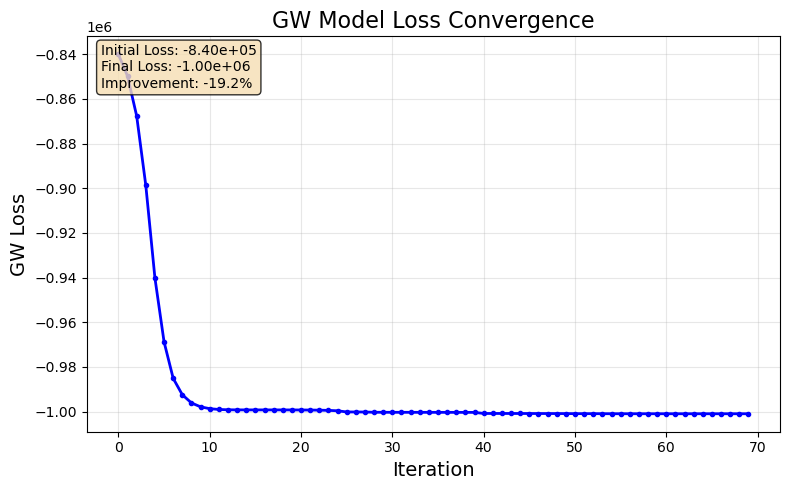

Initial GW Loss: -8.40e+05
Final GW Loss: -1.00e+06
Improvement: -19.2%
Total iterations: 70


In [108]:
# Plot GW loss convergence
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(len(gw_extra_fields['loss_history'])), gw_extra_fields['loss_history'], 
        linewidth=2, color='blue', marker='o', markersize=3)
ax.set_ylabel("GW Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_title("GW Model Loss Convergence", fontsize=16)
ax.grid(True, alpha=0.3)
# ax.set_yscale('log')  # Log scale for better visualization

# Add some statistics
initial_loss = gw_extra_fields['loss_history'][0]
final_loss = gw_extra_fields['loss_history'][-1]
improvement = ((initial_loss - final_loss) / initial_loss) * 100

ax.text(0.02, 0.98, f'Initial Loss: {initial_loss:.2e}\nFinal Loss: {final_loss:.2e}\nImprovement: {improvement:.1f}%', 
        transform=ax.transAxes, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print loss statistics
print(f"Initial GW Loss: {initial_loss:.2e}")
print(f"Final GW Loss: {final_loss:.2e}")
print(f"Improvement: {improvement:.1f}%")
print(f"Total iterations: {len(gw_extra_fields['loss_history'])}")

In [109]:
# Fisher Information Matrix computation for GW model
@jax.jit
def gw_loss_constrained(params_const):
    params_unconst = gw_model.unconstrain(params_const)
    return gw_loss(params_unconst)

@jax.jit
def gw_hessian_constrained(params_const):
    return jax.jacfwd(jax.jacrev(gw_loss_constrained))(params_const)

# Compute Fisher matrix
gw_fisher_matrix = gw_hessian_constrained(gw_model.constrain(gw_best_fit))  # pytree
gw_fisher_matrix, _ = jax.flatten_util.ravel_pytree(gw_fisher_matrix)  # get the array
gw_fisher_matrix = gw_fisher_matrix.reshape((gw_model.num_parameters, gw_model.num_parameters))  # reshape as a matrix
gw_cov_matrix = jnp.linalg.inv(gw_fisher_matrix)  # invert to get covariance matrix

print(f"GW Fisher matrix shape: {gw_fisher_matrix.shape}")
print(f"GW Covariance matrix shape: {gw_cov_matrix.shape}")

GW Fisher matrix shape: (9, 9)
GW Covariance matrix shape: (9, 9)


In [110]:
gw_kwargs_best_fit['kwargs_lens']

[{'theta_E': Array(0.9999005, dtype=float64),
  'center_x': Array(-7.59572596e-07, dtype=float64),
  'center_y': Array(-1.23947585e-07, dtype=float64)}]

In [111]:
import numpy as np
# Generate samples from the posterior using Fisher matrix
gw_mean, gw_unravel_fn = jax.flatten_util.ravel_pytree(gw_model.constrain(gw_best_fit))
gw_cov = gw_cov_matrix
gw_fim_samples = jax.vmap(gw_unravel_fn)(np.random.multivariate_normal(gw_mean, gw_cov, size=3000))

print(f"Generated {len(gw_fim_samples)} samples from GW posterior")
print(f"Sample shape: {gw_fim_samples.keys()}")

Generated 9 samples from GW posterior
Sample shape: dict_keys(['Tstar', 'dL', 'image_x1', 'image_x2', 'image_y1', 'image_y2', 'lens_center_x', 'lens_center_y', 'lens_theta_E'])


/var/folders/_n/04pjt7pn32d2tvw60qhfvhzh0000gn/T/ipykernel_3482/1801463081.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gw_fim_samples = jax.vmap(gw_unravel_fn)(np.random.multivariate_normal(gw_mean, gw_cov, size=3000))


In [112]:
gw_fim_samples['lens_theta_E']   

Array([0.99989965, 0.99990046, 0.99990093, ..., 0.99990034, 0.99990096,
       0.99990015], dtype=float64)

In [113]:
gw_param_names = list(gw_fim_samples.keys())

In [114]:
gw_param_names

['Tstar',
 'dL',
 'image_x1',
 'image_x2',
 'image_y1',
 'image_y2',
 'lens_center_x',
 'lens_center_y',
 'lens_theta_E']

In [115]:
truths = gw_kwargs_best_fit['kwargs_lens'][0]
gw_best_fits = [
    gw_kwargs_best_fit['Tstar'],
    gw_kwargs_best_fit['dL'],
    gw_kwargs_best_fit['image_positions'][0][0],
    gw_kwargs_best_fit['image_positions'][1][0],
    gw_kwargs_best_fit['image_positions'][0][1],
    gw_kwargs_best_fit['image_positions'][1][1],
    gw_kwargs_best_fit['kwargs_lens'][0]['center_x'],
    gw_kwargs_best_fit['kwargs_lens'][0]['center_y'],
    gw_kwargs_best_fit['kwargs_lens'][0]['theta_E'],
]

gw_inputs = [Tstar_true.value, dL_true.value, x_image_true[0], x_image_true[1], y_image_true[0], y_image_true[1], kwargs_lens_true_sis[0]['center_x'], kwargs_lens_true_sis[0]['center_y'], kwargs_lens_true_sis[0]['theta_E']]

In [116]:
gw_inputs

[np.float64(7435213.8456442775),
 np.float64(15924.566651659155),
 np.float64(1.8000000000000045),
 np.float64(-0.19999999999999996),
 np.float64(4.663040014975443e-15),
 np.float64(5.701975682178229e-21),
 0.0,
 0.0,
 1.0]

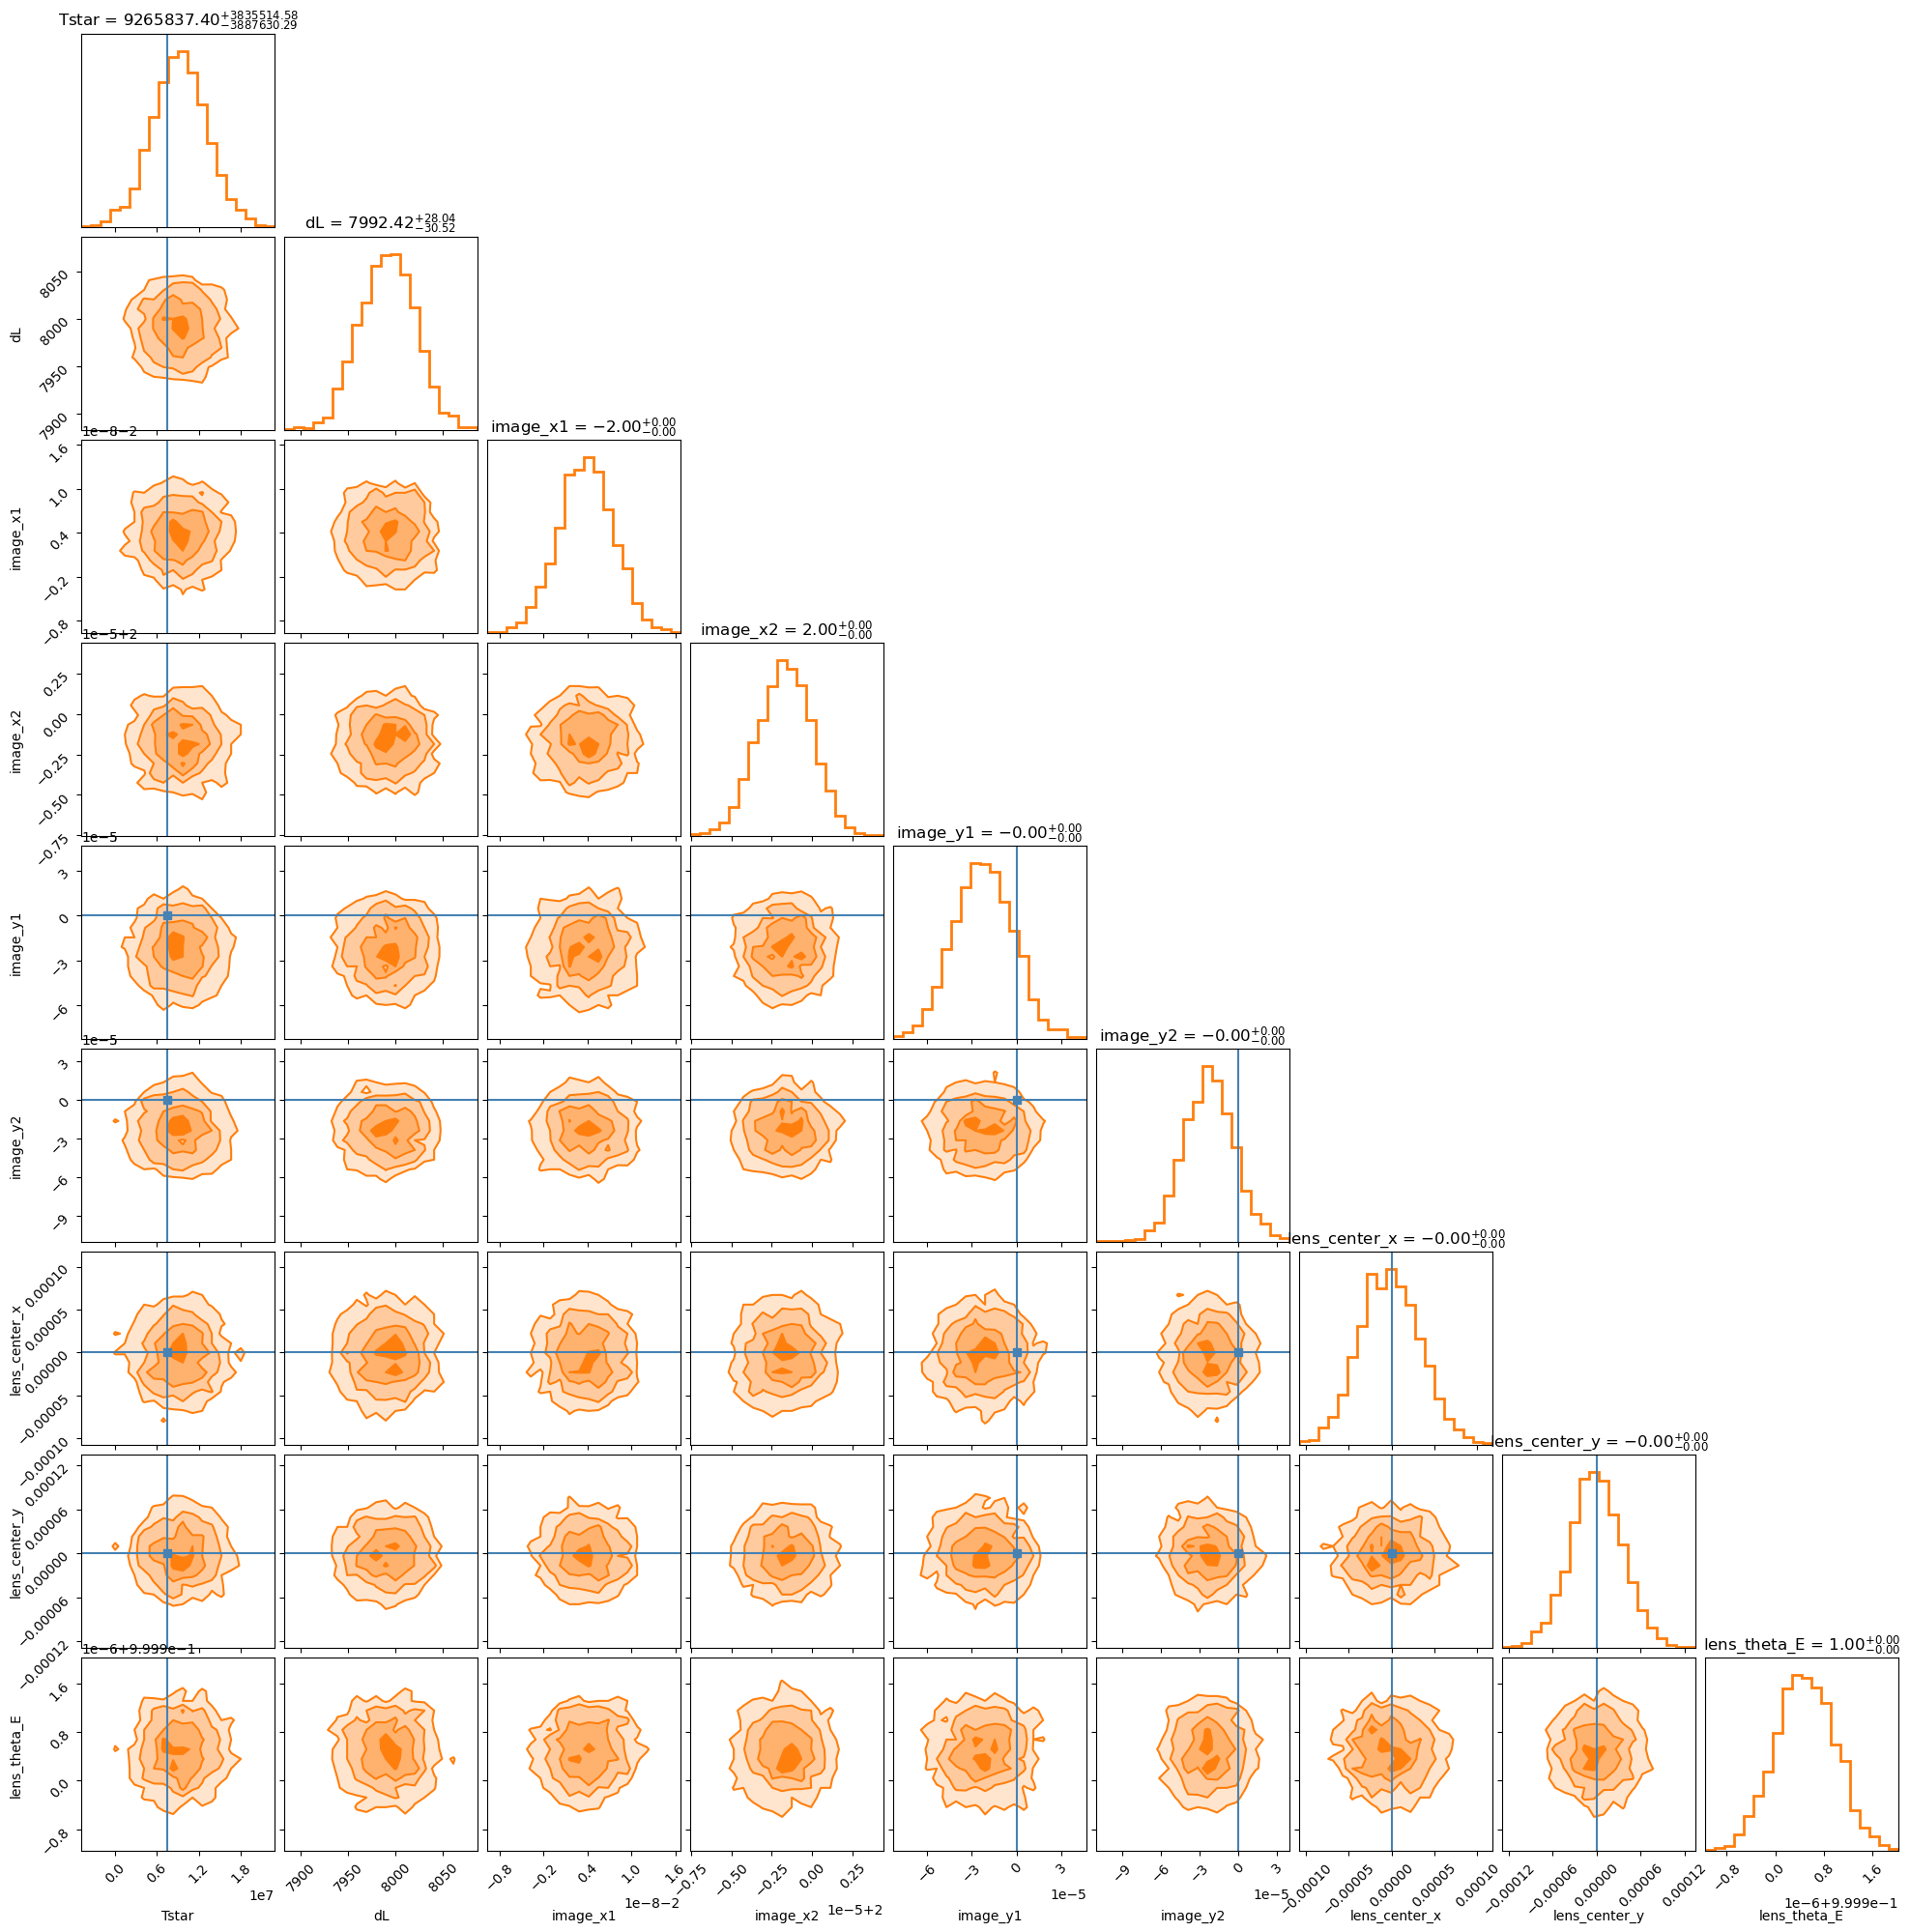

In [117]:
fig = corner.corner(gw_fim_samples, 
                    color='tab:orange', 
                    var_names=gw_param_names,
                    fill_contours=True,
                    plot_datapoints=False,
                    truths=gw_inputs,
                    show_titles=True,
                    hist_kwargs=dict(label="GW Fisher matrix estimate", linewidth=2))

(array([  4.,  40., 185., 545., 832., 807., 442., 117.,  25.,   3.]),
 array([0.99998867, 0.99998904, 0.99998942, 0.99998979, 0.99999016,
        0.99999054, 0.99999091, 0.99999128, 0.99999166, 0.99999203,
        0.99999241]),
 <BarContainer object of 10 artists>)

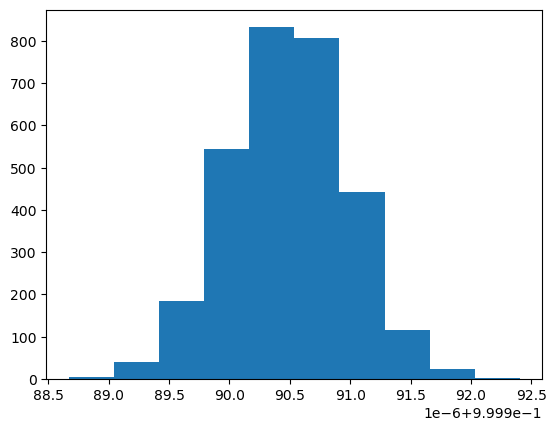

In [100]:
plt.hist(gw_fim_samples['lens_theta_E'])
